# Ingredient match experiment

This notebook was created to experiment with sentence transformers to connect Kafoodle taxonomy with the ingredient database

In [1]:
### Import packages

import os
import time
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sqlalchemy import create_engine

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
### Download models from sentence transformer package

model = SentenceTransformer('paraphrase-mpnet-base-v2')

In [3]:
### Define constants

EXCEL_PATH = 'excel/'
PARQUET_PATH = 'parquet/'
CSV_PATH = 'csv/'
RANDOM_SEED = 888

PLOT_SETUP = {'title': 18,
              'subtitle': 16,
              'label': 14,
              'tick': 12,
              'legend': 14}

In [4]:
### Define DB connection

DB_NAME_STAGE = os.environ['DB_NAME_STAGE']
DB_HOST_STAGE = os.environ['DB_HOST_STAGE']
DB_PORT_STAGE = os.environ['DB_PORT_STAGE']
DB_USERNAME_STAGE = os.environ['DB_USERNAME_STAGE']
DB_PASSWORD_STAGE = os.environ['DB_PASSWORD_STAGE']

TABLE_NAME_TAXONOMY = 'kp_ingredient_taxonomy'
TABLE_NAME_INGREDIENTS = 'kp_ingredients_base_pantry'

STRING_CONN = f'mysql+pymysql://{DB_USERNAME_STAGE}:{DB_PASSWORD_STAGE}@{DB_HOST_STAGE}:{DB_PORT_STAGE}/{DB_NAME_STAGE}'

In [5]:
### Define functions

def _get_key():
    '''
    This function returns a string with the current timestamp.

    Returns
    -------
    key : string with current timestamp
    '''
    dt_now = datetime.now(tz=timezone.utc)
    KEY = (
        dt_now.strftime("%Y-%m-%d")
        + "-"
        + dt_now.strftime("%H")
        + "-"
        + dt_now.strftime("%M")
        + "_"
    )
    return KEY;

def extract_data_sql(tableName, string_conn):
    '''
    Retrieves a given table in the database and stores it in a pandas DataFrame

    Parameters
    ----------
    tableName : string
        Name of table in the database
    string_conn : string
        String containing connection protocol to database.

    Returns
    -------
    DataFrame
        Dataframe containing the table.

    '''
    
    sqlEngine = create_engine(string_conn)
    dbConnection = sqlEngine.connect()
    
    try:
        df = pd.read_sql_table(tableName, dbConnection)
        print('Query successfully executed')
        return df;

    except Exception as ex:   
        print(ex)

    finally:
        dbConnection.close()
 
# Get vectorized standardised taxonomy
def get_vectorised_taxonomy(df, vec_model):
    
    dict_vector = {}
    
    list_categories = df['category_id'].unique()
    
    for CAT in list_categories:
        df_filtered = df[df['category_id'] == CAT].reset_index(drop = True) # Drop index to avoid error in encoding
        list_names = df_filtered['ingredient_name'].tolist()
        array_vectors = model.encode(df_filtered['ingredient_name'])
        
        dict_vector[CAT] = {'ingredient_names': list_names,
                           'vectorized_representation': array_vectors}
    
    return dict_vector;

# Match taxonomy with vectorised ingredients
def match_ingredients(df, vec_model, dict_vector_taxonomy):

    DF_COLS = df.columns.tolist()
    DF_COLS.extend(['matched_ingredient', 'matched_score'])

    return_df = pd.DataFrame(columns = DF_COLS)

    for CAT in dict_vector_taxonomy.keys():
    # for CAT in [101]:
        df_filtered = df[df['category_id'] == CAT].reset_index(drop = True) # Drop index to avoid error in encoding
        list_names = dict_vector_taxonomy[CAT]['ingredient_names']
        taxonomy_scores = dict_vector_taxonomy[CAT]['vectorized_representation']

        if len(df_filtered) == 0: # Continue if no ingredient is found from this category
            continue

        # Enconde ingredients
        encoded_ingredients = vec_model.encode(df_filtered['ingredient_name'])

        # Calculate cosine similarity
        cosine_matrix = cosine_similarity(encoded_ingredients, taxonomy_scores)

        # Get best match
        best_score_idx = np.argmax(cosine_matrix, axis = 1)

        # Assign ingredient and score to df
        matched_ingredient = [list_names[i] for i in best_score_idx]
        matched_score = [cosine_matrix[i][j] for i, j in enumerate(best_score_idx)]

        df_filtered['matched_ingredient'] = matched_ingredient
        df_filtered['matched_score'] = matched_score

        # Append to final df
        return_df = pd.concat([return_df, df_filtered])

    # Reset index
    return_df.reset_index(drop = True, inplace = True)
    
    return return_df;

# Must separate the actual cosine calculation from the categories. In that way, it can be timed for efficiency

In [6]:
### Read data

df_taxonomy = extract_data_sql(TABLE_NAME_TAXONOMY, STRING_CONN)
df_ingredients = extract_data_sql(TABLE_NAME_INGREDIENTS, STRING_CONN)

Query successfully executed
Query successfully executed


In [7]:
### Estimate vectorised taxonomy 

dict_vectorised_taxonomy = get_vectorised_taxonomy(df_taxonomy, model)
dict_vectorised_taxonomy

{101: {'ingredient_names': ['crab',
   'lobsters',
   'gambas',
   'prawns',
   'shrimp-skewers',
   'jumbo-shrimps',
   'shrimps-tails',
   'spider-crab',
   'spiny-lobsters',
   'anchovy',
   'anglers',
   'bass',
   'breams',
   'cod-fillets',
   'cod-livers',
   'canned-herrings',
   'pacific-herring',
   'pickled-herring',
   'smoked-herrings',
   'mackerel-fillets-in-escabeche',
   'mackerel-fillets-in-mustard-sauce',
   'mackerel-fillets-in-oil',
   'mackerel-fillets-in-white-wine-and-herbs',
   'mackerels-fillets-with-olives-and-lemon',
   'mackerels-fillets-with-tomato-and-basilisk',
   'plain-mackerels-fillets',
   'tinned-mackerels',
   'pollock-fillets',
   'canned-salmons',
   'salmon-fillets',
   'salmons-from-farming',
   'smoked-salmons-from-farming',
   'wild-smoked-salmons',
   'sardines-in-oil-and-lemon',
   'sardines-in-sunflower-oil',
   'sardines-in-tomato-sauce',
   'sardines-without-oil',
   'smoked-trouts',
   'atlantic-bluefin-tunas',
   'bigeye-tunas',
   'ca

In [8]:
### Match ingredients with taxonomy

INIT_TIME = time.time()

# df_matched_ingredients = match_ingredients(df_ingredients.sample(n = 50, random_state = RANDOM_SEED), model, dict_vectorised_taxonomy)
df_matched_ingredients = match_ingredients(df_ingredients, model, dict_vectorised_taxonomy)

FINAL_TIME = time.time() - INIT_TIME

print(f'Time to compute function: {FINAL_TIME:.2f} seconds')

# Export results
filename = f'{CSV_PATH}{_get_key()}matched_ingredients.csv'
df_matched_ingredients.to_csv(filename, index = False)

Time to compute function: 1961.38 seconds


Distribution of groups:
    group  distribution
0    high      0.108815
1  medium      0.485978
2    poor      0.405207



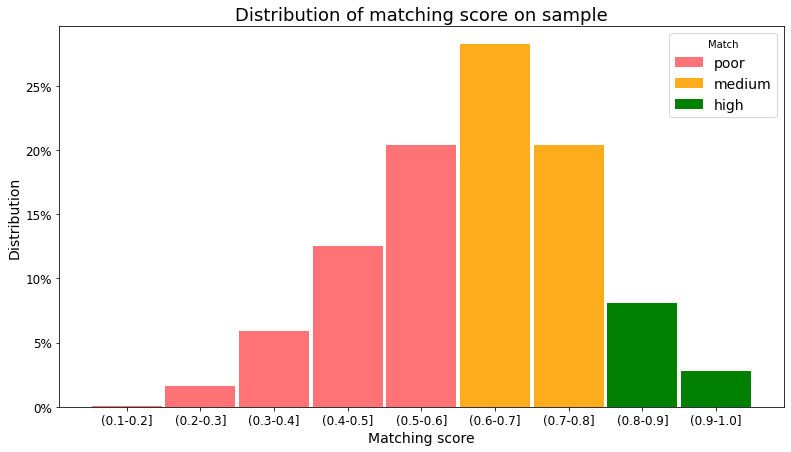

In [9]:
### Plot ingredient histogram

df_matched_ingredients_plot = df_matched_ingredients[['matched_score']]

# Transform dataframe to format plot
df_matched_ingredients_plot.loc[df_matched_ingredients_plot['matched_score'] < 0, 'matched_score'] = 0.1
df_matched_ingredients_plot.loc[df_matched_ingredients_plot['matched_score'] > 1, 'matched_score'] = 1
df_matched_ingredients_plot['rounded_score'] = np.ceil(df_matched_ingredients_plot['matched_score'] * 10) / 10

# Group data for plot
df_matched_ingredients_plot = pd.DataFrame(df_matched_ingredients_plot['rounded_score'].value_counts())
df_matched_ingredients_plot.reset_index(inplace = True)
df_matched_ingredients_plot.rename(columns = {'index': 'score', 'rounded_score': 'count'}, inplace = True)
df_matched_ingredients_plot.sort_values(by = 'score', inplace = True)
df_matched_ingredients_plot.reset_index(drop = True, inplace = True)
df_matched_ingredients_plot['distribution'] = df_matched_ingredients_plot['count'] / sum(df_matched_ingredients_plot['count'])
df_matched_ingredients_plot['group'] = 'poor'
df_matched_ingredients_plot.loc[df_matched_ingredients_plot['score'] > 0.6, 'group'] = 'medium'
df_matched_ingredients_plot.loc[df_matched_ingredients_plot['score'] > 0.8, 'group'] = 'high'
df_matched_ingredients_plot.reset_index(inplace = True)

# Save data
filename = f'{CSV_PATH}{_get_key()}plot_histogram.csv'
df_matched_ingredients_plot.to_csv(filename, index = False)

# Compute distribution per group
df_MIP_plot = df_matched_ingredients_plot[['group', 'distribution']].groupby(['group'], as_index = False).sum()

print('Distribution of groups:')
print(df_MIP_plot)
print('')

# Compute axes and colours
COLOURS = {'poor': '#ff7276',
          'medium': '#ffac1c',
          'high': '#008000'}

df_axis = df_matched_ingredients_plot[['score']].rename(columns = {'score': 'upper_limit'})
df_axis['lower_limit'] = df_axis['upper_limit'] - 0.1
df_axis['lower_limit'] = np.round(df_axis['lower_limit'], 1)
df_axis['upper_limit'] = np.round(df_axis['upper_limit'], 1)
df_axis['tag'] = '(' + df_axis['lower_limit'].apply(str) + '-' + df_axis['upper_limit'].apply(str) + ']'
df_axis.reset_index(inplace = True)

# Plot histogram
fig = plt.figure(1, (13, 7))
ax = fig.add_subplot(1, 1, 1)

for key in COLOURS.keys():
    DF_PLOT = df_matched_ingredients_plot[df_matched_ingredients_plot['group'] == key]
    
    ax.bar(x = DF_PLOT['index'],
           height = DF_PLOT['distribution'] * 100,
           width = 0.95,
           label = key,
           color = COLOURS[key])
# Set x ticks
ax.set_xticks(df_axis['index'])
ax.set_xticklabels(df_axis['tag'])

# Set percentage axis
yticks = mticker.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(yticks)

# Set labels
ax.set_xlabel('Matching score', fontsize = PLOT_SETUP['label'])
ax.set_ylabel('Distribution', fontsize = PLOT_SETUP['label'])

# Set title
ax.set_title('Distribution of matching score on sample', fontsize = PLOT_SETUP['title'])

# Set tick size
ax.tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])

# Set legend
ax.legend(loc = 'best', fontsize = PLOT_SETUP['legend'], title = 'Match')

plt.show()

In [10]:
df_matched_ingredients.sample(20, random_state = RANDOM_SEED).\
    sort_values(by = ['category_id', 'matched_score'], ascending = [True, False])#.\
#     to_excel(EXCEL_PATH + 'matching_sample.xlsx')

,ingredient_id,category_id,ingredient_name,date_created,matched_ingredient,matched_score
1907,861106,101,Pier 7 MSC Extra Large Cod Fillets Skinless & ...,2021-09-03 07:38:00,cod-fillets,0.765077
3178,1033966,101,MSC Large Haddock Fillets Skinless & Boneless ...,2021-10-12 13:43:20,cod-fillets,0.6783
15135,976087,102,Farmstead Pork Sausage Chipolata 16s -,2021-09-29 13:05:13,pork-ribs,0.627039
7483,716165,102,Farmstead Puck Burger 113g,2021-05-20 15:08:51,ground-beef,0.573611
20167,1096587,102,Farmstead Whole Chicken Red Tractor -,2021-10-29 16:14:27,chicken-wings,0.43053
26676,715603,103,(Prep 2pm) - 3mm SLICED CARROTS x 2.5Kg Pack O...,2021-05-20 14:37:44,canned-carrots,0.72057
39502,1245142,103,2.5kg Sliced Piquillo Peppers,2022-05-05 11:03:17,canned-peppers,0.6881
28973,807673,103,BB - BABY HERITAGE CARROT D4,2021-08-27 21:53:03,carrots,0.671882
36914,1145422,103,Leek Baby Legumes 400g Sp,2022-02-02 17:56:01,leeks,0.61309
31114,935248,103,Lamb Weston Luxury Homestyle Mash,2021-09-15 11:55:28,fennel-bulbs,0.319801
